In [1]:
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import noisereduce as nr
import pywt
import warnings
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import jiwer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Dropout, GlobalAveragePooling1D, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
import numpy as np
import seaborn as sns
from scipy.signal import butter, sosfiltfilt

from tensorflow.keras.models import load_model


# Mengabaikan peringatan untuk tampilan yang lebih bersih
warnings.filterwarnings('ignore')

c:\Users\gabry\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Konfigurasi parameter global
SAMPLE_RATE = 16000
N_MFCC = 13
N_MELS = 22
WINDOW = int(SAMPLE_RATE * 0.01) # Ukuran jendela untuk FFT (0.01 detik)
HOP = int(SAMPLE_RATE * 0.005)  # Ukuran hop untuk FFT (0.005 detik)
COMMANDS = ["baca", "berhenti", "foto", "halo", "info", "kembali", "ulang"] # Daftar perintah yang dikenali

In [3]:
# Fungsi untuk memuat file audio
def load_audio(file_path, sr=SAMPLE_RATE):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio / np.max(np.abs(audio)) # Normalisasi audio

# Fungsi untuk menerapkan filter bandpass
def bandpass_filter(audio, lowcut=300, highcut=3400, sr=SAMPLE_RATE, order=5):
    sos = butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return sosfiltfilt(sos, audio)

# Fungsi untuk mengurangi noise
def reduce_noise(audio):
    return nr.reduce_noise(y=audio, sr=SAMPLE_RATE)

# Fungsi untuk preprocessing audio lengkap
def preprocess_audio(file_path):
    audio = load_audio(file_path)
    audio = bandpass_filter(audio)
    return reduce_noise(audio)

In [4]:
# Fungsi untuk mengekstrak fitur MFCC
def extract_mfcc(signal):
    return librosa.feature.mfcc(
        y=signal,
        sr=SAMPLE_RATE,
        n_mfcc=N_MFCC,
        n_mels=N_MELS,
        n_fft=WINDOW,
        hop_length=HOP
    ).T # Transposisi untuk mendapatkan bentuk [timesteps, n_mfcc]

In [5]:
# Fungsi untuk memuat dataset dari direktori
def load_dataset(directory, commands):
    data = []
    for label in commands:
        folder = os.path.join(directory, label)
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                data.append((os.path.join(folder, file), label))
    return pd.DataFrame(data, columns=["speech", "label"])

# Fungsi untuk mengekstrak fitur dari DataFrame
def extract_features(df):
    print("Preprocessing and extracting features...")
    features = Parallel(n_jobs=-1)( # Menggunakan semua core CPU yang tersedia
        delayed(lambda path: extract_mfcc(preprocess_audio(path)))(fp)
        for fp in tqdm(df['speech'], desc="Extracting")
    )
    df['mfcc'] = features
    return df

# Fungsi untuk encoding label dan padding fitur
def encode_and_pad(df_train, df_valid):
    le = LabelEncoder()
    df_train['label_encoded'] = le.fit_transform(df_train['label'])
    df_valid['label_encoded'] = le.transform(df_valid['label'])

    all_mfcc = df_train['mfcc'].tolist() + df_valid['mfcc'].tolist()
    max_len = max(len(x) for x in all_mfcc) # Menentukan panjang maksimum untuk padding

    X_train = pad_sequences(df_train['mfcc'], maxlen=max_len, padding='post', dtype='float32')
    X_valid = pad_sequences(df_valid['mfcc'], maxlen=max_len, padding='post', dtype='float32')

    y_train = to_categorical(df_train['label_encoded'])
    y_valid = to_categorical(df_valid['label_encoded'])

    return X_train, y_train, X_valid, y_valid, le

In [6]:
# Definisi Custom LSTM Layer dengan Forget Gate berbasis RNN
class CustomLSTMWithRNNForgetGate(Layer):
    def __init__(self, units, input_dim, return_sequences=False, **kwargs):
        super(CustomLSTMWithRNNForgetGate, self).__init__(**kwargs)
        self.units = units
        self.input_dim = input_dim
        # return_sequences di sini untuk internal sel, bukan output wrapper RNN
        self.return_sequences = return_sequences

        # Bobot untuk gate LSTM standar (input, output, pembaruan sel)
        self.kernel_i = self.add_weight(shape=(input_dim, units), initializer='glorot_uniform', name='kernel_i')
        self.kernel_o = self.add_weight(shape=(input_dim, units), initializer='glorot_uniform', name='kernel_o')
        self.kernel_c = self.add_weight(shape=(input_dim, units), initializer='glorot_uniform', name='kernel_c')
        self.recurrent_kernel_i = self.add_weight(shape=(units, units), initializer='glorot_uniform', name='recurrent_kernel_i')
        self.recurrent_kernel_o = self.add_weight(shape=(units, units), initializer='glorot_uniform', name='recurrent_kernel_o')
        self.recurrent_kernel_c = self.add_weight(shape=(units, units), initializer='glorot_uniform', name='recurrent_kernel_c')
        self.bias_i = self.add_weight(shape=(units,), initializer='zeros', name='bias_i')
        self.bias_o = self.add_weight(shape=(units,), initializer='zeros', name='bias_o')
        self.bias_c = self.add_weight(shape=(units,), initializer='zeros', name='bias_c')

        # Bobot untuk forget gate berbasis RNN
        self.rnn_kernel_f = self.add_weight(shape=(input_dim, units), initializer='glorot_uniform', name='rnn_kernel_f')
        self.rnn_recurrent_kernel_f = self.add_weight(shape=(units, units), initializer='glorot_uniform', name='rnn_recurrent_kernel_f')
        self.rnn_bias_f = self.add_weight(shape=(units,), initializer='zeros', name='rnn_bias_f')

    @property
    def state_size(self):
        # Mengembalikan ukuran state untuk h_t (hidden), c_t (cell), f_t (forget)
        return (self.units, self.units, self.units)

    def build(self, input_shape):
        # Memungkinkan bentuk 2D (batch_size, features) selama build awal
        if len(input_shape) < 2 or len(input_shape) > 3:
            raise ValueError(f"Expected input shape with 2 or 3 dimensions [batch_size, [timesteps], input_dim], got {input_shape}")
        if input_shape[-1] != self.input_dim:
            raise ValueError(f"Last dimension of input shape {input_shape[-1]} must match input_dim {self.input_dim}")
        self.built = True

    def call(self, inputs, states=None, training=None):
        # Wrapper tf.keras.layers.RNN akan memberi input 2D (inputs_t) untuk setiap timestep
        # ke fungsi langkah (step) sel ini.
        # Metode `call` ini secara efektif mendefinisikan logika langkah `cell`.
        # Wrapper `tf.keras.layers.RNN` menangani iterasi di atas `timesteps`.

        # Inisialisasi state jika None (untuk langkah pertama)
        if states is None:
            batch_size = tf.shape(inputs)[0]
            h_tm1 = tf.zeros([batch_size, self.units], dtype=inputs.dtype)
            c_tm1 = tf.zeros([batch_size, self.units], dtype=inputs.dtype)
            f_tm1 = tf.zeros([batch_size, self.units], dtype=inputs.dtype)
        else:
            h_tm1, c_tm1, f_tm1 = states

        inputs_t = inputs # Input ke metode call sel akan menjadi (batch_size, input_dim)

        # Gate input
        i_t = tf.sigmoid(tf.matmul(inputs_t, self.kernel_i) + tf.matmul(h_tm1, self.recurrent_kernel_i) + self.bias_i)
        # Gate output
        o_t = tf.sigmoid(tf.matmul(inputs_t, self.kernel_o) + tf.matmul(h_tm1, self.recurrent_kernel_o) + self.bias_o)
        # Pembaruan sel
        c_tilde = tf.tanh(tf.matmul(inputs_t, self.kernel_c) + tf.matmul(h_tm1, self.recurrent_kernel_c) + self.bias_c)
        # Forget gate (berbasis RNN)
        f_t = tf.sigmoid(tf.matmul(inputs_t, self.rnn_kernel_f) + tf.matmul(f_tm1, self.rnn_recurrent_kernel_f) + self.rnn_bias_f)

        # State sel
        c_t = f_t * c_tm1 + i_t * c_tilde
        # State tersembunyi
        h_t = o_t * tf.tanh(c_t)

        return h_t, [h_t, c_t, f_t] # Mengembalikan output dan state baru

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if batch_size is None:
            batch_size = tf.shape(inputs)[0] if inputs is not None else 1
        if dtype is None:
            dtype = tf.float32
        return [
            tf.zeros([batch_size, self.units], dtype=dtype),
            tf.zeros([batch_size, self.units], dtype=dtype),
            tf.zeros([batch_size, self.units], dtype=dtype)
        ]

    def get_config(self):
        config = super(CustomLSTMWithRNNForgetGate, self).get_config()
        config.update({
            'units': self.units,
            'input_dim': self.input_dim,
            'return_sequences': self.return_sequences
        })
        return config


In [7]:
# Fungsi untuk membangun model sekuensial
def build_model(input_shape, num_classes):
    print(f"Membangun model dengan input_shape: {input_shape}")
    model = Sequential([
        # Masking layer mengharapkan input 3D
        Masking(mask_value=0.0, input_shape=input_shape),
        # Lapisan RNN kemudian akan mengiterasi timesteps dari input 3D ini.
        # Fix: Pastikan return_sequences=True agar GlobalAveragePooling1D menerima input 3D
        tf.keras.layers.RNN(CustomLSTMWithRNNForgetGate(units=128, input_dim=input_shape[1]), return_sequences=True),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
# Fungsi untuk melatih model
def train_model(model, X_train, y_train, X_valid, y_valid, batch_size=64, epochs=100):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    return model, history

In [9]:
# Fungsi untuk mengevaluasi model
def evaluate_model(model, X_valid, y_valid, label_encoder):
    start = time.time()

    y_pred_probs = model.predict(X_valid)
    end = time.time()

    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_valid, axis=1)

    print("\n=== Laporan Klasifikasi ===")
    print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_true, y_pred_classes)

    audio_duration_total = (X_valid.shape[0] * X_valid.shape[1]) / SAMPLE_RATE
    rtf = (end - start) / audio_duration_total
    print(f"RTF (Real Time Factor): {rtf:.4f}")

    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    print(f"Presisi (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"Skor F1 (weighted): {f1:.4f}")

    return {
        'RTF': rtf,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'y_true': y_true,
        'y_pred': y_pred_classes,
        'cm': cm
    }

In [10]:
# --- Jalan Program ---
df_train = load_dataset("dataaug/training", COMMANDS)
df_valid = load_dataset("dataaug/validation", COMMANDS)

df_train = extract_features(df_train)
df_valid = extract_features(df_valid)



Preprocessing and extracting features...


Extracting: 100%|██████████| 13489/13489 [02:42<00:00, 83.09it/s] 


Preprocessing and extracting features...


Extracting: 100%|██████████| 1290/1290 [00:13<00:00, 94.91it/s]


In [11]:
X_train, y_train, X_valid, y_valid, le = encode_and_pad(df_train, df_valid)
# Menampilkan pemetaan label
print("Pemetaan label:")
for label, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"'{label}' -> {encoded}")

Pemetaan label:
'baca' -> 0
'berhenti' -> 1
'foto' -> 2
'halo' -> 3
'info' -> 4
'kembali' -> 5
'ulang' -> 6


In [12]:
# Membangun, melatih, dan mengevaluasi model
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=y_train.shape[1])

Membangun model dengan input_shape: (929, 13)


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 929, 13)           0         
                                                                 
 rnn (RNN)                   (None, 929, 128)          72704     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                        

In [14]:
model, history = train_model(model, X_train, y_train, X_valid, y_valid, batch_size=64, epochs=100)

Epoch 1/100
211/211 [==============================] - 1063s 5s/step - loss: 1.6956 - accuracy: 0.4117 - val_loss: 1.2181 - val_accuracy: 0.7093
Epoch 2/100
211/211 [==============================] - 1052s 5s/step - loss: 0.9586 - accuracy: 0.7136 - val_loss: 0.5450 - val_accuracy: 0.8612
Epoch 3/100
211/211 [==============================] - 1054s 5s/step - loss: 0.5407 - accuracy: 0.8396 - val_loss: 0.3161 - val_accuracy: 0.9155
Epoch 4/100
211/211 [==============================] - 1050s 5s/step - loss: 0.3510 - accuracy: 0.9001 - val_loss: 0.1961 - val_accuracy: 0.9488
Epoch 5/100
211/211 [==============================] - 1055s 5s/step - loss: 0.2562 - accuracy: 0.9279 - val_loss: 0.1482 - val_accuracy: 0.9597
Epoch 6/100
211/211 [==============================] - 1061s 5s/step - loss: 0.2012 - accuracy: 0.9438 - val_loss: 0.1152 - val_accuracy: 0.9667
Epoch 7/100
211/211 [==============================] - 1033s 5s/step - loss: 0.1637 - accuracy: 0.9561 - val_loss: 0.0863 - val_ac

In [15]:
# val_accuracy terbaik
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1  
print(f"Val accuracy terbaik: {best_val_acc:.4f} pada epoch ke-{best_epoch}")

Val accuracy terbaik: 0.9969 pada epoch ke-26


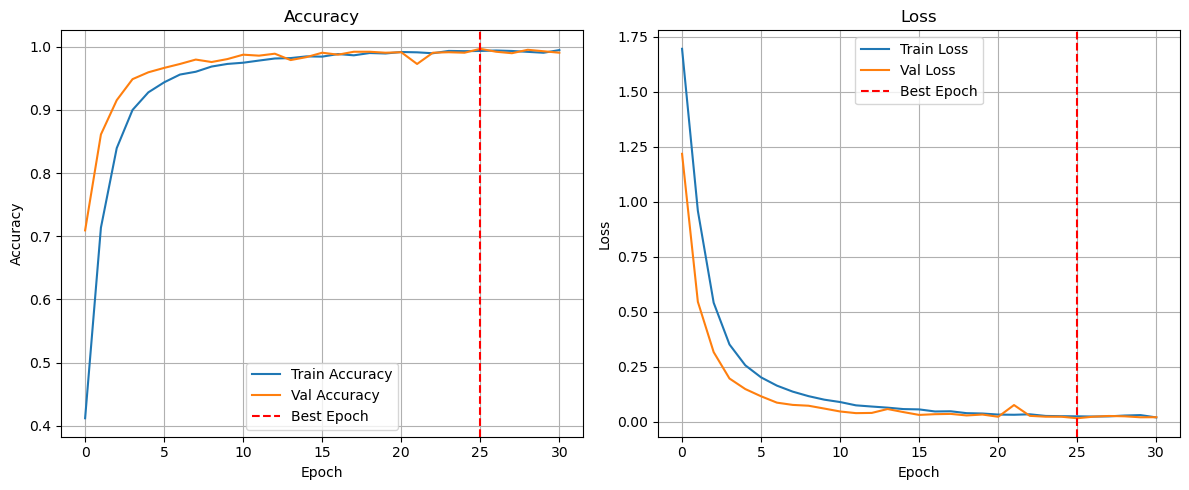

In [16]:
# Grafik akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Grafik loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
metrics = evaluate_model(model, X_valid, y_valid, le)

41/41 [==============================] - 18s 429ms/step

=== Laporan Klasifikasi ===
              precision    recall  f1-score   support

        baca       0.99      1.00      1.00       184
    berhenti       1.00      1.00      1.00       184
        foto       1.00      0.99      0.99       184
        halo       1.00      0.99      1.00       183
        info       0.99      1.00      0.99       183
     kembali       0.99      1.00      1.00       188
       ulang       1.00      0.99      1.00       184

    accuracy                           1.00      1290
   macro avg       1.00      1.00      1.00      1290
weighted avg       1.00      1.00      1.00      1290

RTF (Real Time Factor): 0.2488
Presisi (weighted): 0.9969
Recall (weighted): 0.9969
Skor F1 (weighted): 0.9969


In [18]:
model.save('model/mymodelr2.h5')

# Testing

In [25]:
custom_objects = {'CustomLSTMWithRNNForgetGate': CustomLSTMWithRNNForgetGate}
modeltes = load_model('model/mymodelr2.h5', custom_objects=custom_objects)

In [26]:
# Inisialisasi
y_true, y_pred = [], []
dataset_path = 'datasetuji'

In [27]:
# load audio
all_mfcc = []
for label in COMMANDS:
    folder_path = os.path.join(dataset_path, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            signal = preprocess_audio(file_path)
            mfcc = extract_mfcc(signal)
            all_mfcc.append(mfcc)


max_len = 929  

# preprocessing
y_true = []
y_pred = []
for label, mfcc in zip(
    [label for label in COMMANDS for filename in os.listdir(os.path.join(dataset_path, label)) if filename.endswith('.wav')],
    all_mfcc
):
    # Pad the MFCC sequence to the fixed max_len
    x_input = pad_sequences([mfcc], maxlen=max_len, padding='post', dtype='float32')

    # Make prediction
    prediction = modeltes.predict(x_input)
    pred_label_idx = np.argmax(prediction, axis=1)[0]  # Ensure scalar index

    # Append true and predicted labels
    y_true.append(COMMANDS.index(label))
    y_pred.append(pred_label_idx)

1/1 [==============================] - 1s 518ms/step


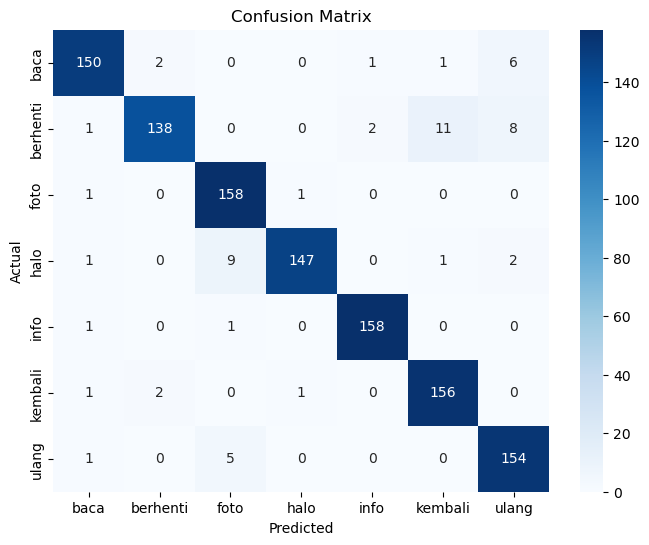

              precision    recall  f1-score   support

        baca       0.96      0.94      0.95       160
    berhenti       0.97      0.86      0.91       160
        foto       0.91      0.99      0.95       160
        halo       0.99      0.92      0.95       160
        info       0.98      0.99      0.98       160
     kembali       0.92      0.97      0.95       160
       ulang       0.91      0.96      0.93       160

    accuracy                           0.95      1120
   macro avg       0.95      0.95      0.95      1120
weighted avg       0.95      0.95      0.95      1120



In [28]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=COMMANDS, yticklabels=COMMANDS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=COMMANDS)
print(report)

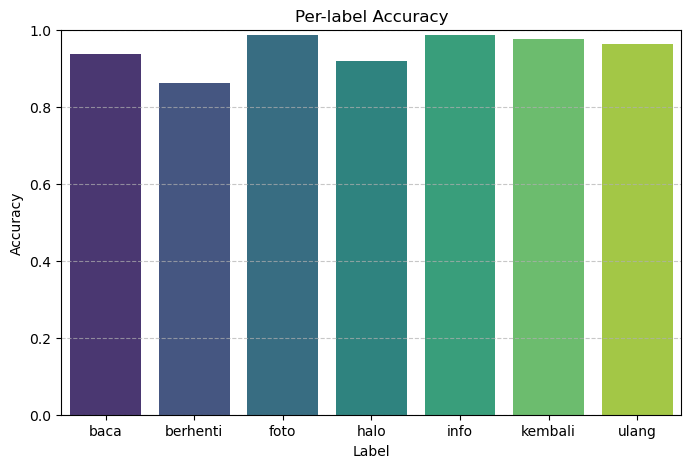

In [29]:
# Akurasi per Label
correct_per_label = np.diag(cm) 
total_per_label = np.sum(cm, axis=1)
accuracy_per_label = correct_per_label / total_per_label

# Bar Chart Akurasi per Label
plt.figure(figsize=(8, 5))
sns.barplot(x=COMMANDS, y=accuracy_per_label, palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title('Per-label Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
